In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
from contextily import add_basemap
from shapely import points

In [ ]:
S2_URL = "s2_2024.tif"

S1_URL = "s1_2024.tif"

SAMPLE_URL = "../data/250204 - Database Riset Mangrove Sofifi Kirim Ramadhan.xlsx"

In [28]:
# Show sample
sample = pd.read_excel(SAMPLE_URL, sheet_name=4)
sample

,Plot,X,Y,Keterangan,AGC,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,FINAL_NDVI,FINALGNDVI,FINAL_NDI4,FINAL_DVI,FINAL_EVI,FINAL_EVI2,FINAL_SAVI,FINAL_CLRE,FINAL_MCAR,FINAL_IREC
0,1,127.603871,0.757227,Training,237.219760,0.02730,0.02485,0.04970,0.02040,0.09040,0.30880,0.38055,0.3744,0.41090,0.39480,0.09285,0.03515,0.896657,0.765621,0.631769,0.35400,0.675353,0.621768,0.593429,3.14159,0.014936,1.209240
1,2,127.603950,0.757402,Training,121.735748,0.02730,0.02700,0.05550,0.02285,0.09825,0.32275,0.39510,0.3812,0.42835,0.39480,0.09415,0.03520,0.886895,0.745821,0.622626,0.35835,0.680860,0.623851,0.594574,2.87990,0.017230,1.177180
2,3,127.603775,0.757593,Validation,181.384978,0.02485,0.02715,0.05070,0.02325,0.09300,0.28980,0.35025,0.3652,0.38045,0.36475,0.08875,0.03420,0.880293,0.756191,0.600000,0.34195,0.657053,0.601601,0.577326,2.92688,0.015608,1.065560
3,4,127.603752,0.757851,Training,184.386956,0.02485,0.03080,0.05475,0.02575,0.09540,0.27680,0.33145,0.3212,0.35940,0.36475,0.09195,0.03620,0.851564,0.708738,0.574907,0.29545,0.593416,0.534074,0.523260,2.36688,0.018272,0.857239
4,5,127.603764,0.758114,Validation,132.651448,0.02810,0.02900,0.05220,0.02660,0.08970,0.26180,0.30960,0.2996,0.33520,0.32160,0.09790,0.04150,0.836910,0.703241,0.542562,0.27300,0.549650,0.500572,0.495643,2.34002,0.016647,0.796783
5,6,127.603320,0.758512,Training,111.827347,0.02825,0.02925,0.05250,0.02530,0.09020,0.26840,0.32245,0.3148,0.35110,0.32390,0.08860,0.03595,0.851220,0.714130,0.561905,0.28950,0.580288,0.526165,0.516903,2.49002,0.016435,0.861439
6,7,127.603596,0.758666,Training,175.276130,0.02760,0.02900,0.05200,0.02560,0.08650,0.25440,0.30860,0.2920,0.33610,0.31690,0.08620,0.03440,0.838791,0.697674,0.543265,0.26640,0.542301,0.492079,0.488748,2.37572,0.015997,0.783493
7,8,127.603775,0.758481,Training,615.277066,0.02810,0.03060,0.04960,0.02760,0.08570,0.23500,0.28120,0.2668,0.30790,0.32160,0.09160,0.03870,0.812500,0.686473,0.512798,0.23920,0.497132,0.448599,0.451662,2.11319,0.016343,0.655916
8,9,127.604121,0.758465,Training,76.502252,0.02930,0.03360,0.05160,0.03065,0.08540,0.21305,0.25070,0.2424,0.27785,0.29005,0.09685,0.04270,0.775499,0.648980,0.471779,0.21175,0.450801,0.402273,0.410873,1.83841,0.016907,0.528259
9,10,127.604133,0.758657,Validation,108.595516,0.02945,0.03325,0.05160,0.03100,0.08520,0.21285,0.25730,0.2458,0.28290,0.28865,0.09390,0.04055,0.776012,0.652993,0.466437,0.21480,0.454151,0.406757,0.414779,1.88498,0.016458,0.536622


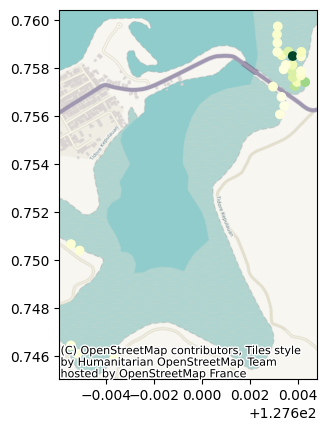

In [31]:
# Make sample ito geodataframe
geometry = points(sample["X"], sample["Y"])
sample = gpd.GeoDataFrame(sample, geometry=geometry, crs="EPSG:4326")

ax = sample.plot(column="AGC", cmap="YlGn")
add_basemap(ax=ax, crs="EPSG:4326")

In [41]:
indices = [
    dict(name="NDMI", band1="NIR", band2="SWIR1", cmap="RdYlGn"),
    dict(name="NBR", band1="NIR", band2="SWIR2", cmap="RdYlGn"),
    dict(name="NBR2", band1="SWIR1", band2="SWIR2", cmap="RdYlGn"),
    # dict(name="NDWI", band1="GREEN", band2="NIR", cmap="RdBu"),
    dict(name="MNDWI", band1="GREEN", band2="SWIR1", cmap="RdBu"),
    dict(name="MNDWI2", band1="GREEN", band2="SWIR2", cmap="RdBu"),
    dict(name="NDVI", band1="NIR", band2="RED", cmap="RdYlGn"),
    dict(name="NDTI", band1="RED", band2="GREEN", cmap="Reds"),
    dict(name="GNDVI", band1="NIR", band2="GREEN", cmap="RdYlGn"),
    dict(name="NDI45", band1="RE1", band2="RED", cmap="RdYlGn"),
]
band_map_s2 = dict(
    COASTAl=0,
    BLUE=1,
    GREEN=2,
    RED=3,
    RE1=4,
    RE2=5,
    RE3=6,
    NIR=7,
    RE4=8,
    WV=9,
    SWIR1=10,
    SWIR2=11,
)

In [45]:
# Sample images
extract = sample.copy()[["AGC"]]
coords = [coord for coord in zip(sample.geometry.x, sample.geometry.y)]

# Bands
bands_s2 = [
    "COASTAL",
    "BLUE",
    "GREEN",
    "RED",
    "RE1",
    "RE2",
    "RE3",
    "NIR",
    "RE4",
    "WV",
    "SWIR1",
    "SWIR2",
]

bands_s1 = ["VV", "VH"]

with rio.open(S2_URL) as source:
    extract[bands_s2] = [data / 1e4 for data in source.sample(coords)]

with rio.open(S1_URL) as source:
    extract[bands_s1] = [data / 1e4 for data in source.sample(coords)]

# Filter sample
extract = extract[(extract["BLUE"] > 0) & (extract["VV"] > 0)]

# Calculate indices
for x in range(len(indices)):
    index = indices[x]
    name = index["name"]
    band1 = index["band1"]
    band2 = index["band2"]

    extract[name] = (extract[band1] - extract[band2]) / (
        extract[band1] + extract[band2]
    )

# Calculate other custom indices
extract["DVI"] = extract["NIR"] - extract["RED"]
extract["EVI"] = (
    2.5
    * (extract["NIR"] - extract["RED"])
    / (extract["NIR"] + 6 * extract["RED"] - 7.5 * extract["BLUE"] + 1)
)
extract["EVI2"] = (
    2.5
    * (extract["NIR"] - extract["RED"])
    / (extract["NIR"] + 2.4 * extract["RED"] + 1)
)
extract["SAVI"] = (
    1.5 * (extract["NIR"] - extract["RED"]) / (extract["NIR"] + extract["RED"] + 0.5)
)
extract["CLRE"] = (extract["NIR"] / extract["RE1"]) - 1
extract["MCARI"] = (
    ((extract["RE1"] - extract["RED"]) - (0.2 * extract["RE1"] - extract["GREEN"]))
    * extract["RE1"]
    / extract["NIR"]
)
extract["IRECI"] = (extract["NIR"] - extract["RED"]) / (extract["RE1"] / extract["RE2"])
extract["RVI"] = (4 * extract["VH"]) / (extract["VV"] / extract["VH"])

extract

,AGC,COASTAL,BLUE,GREEN,RED,RE1,RE2,RE3,NIR,RE4,WV,SWIR1,SWIR2,VV,VH,NDMI,NBR,NBR2,MNDWI,MNDWI2,NDVI,NDTI,GNDVI,NDI45,DVI,EVI,EVI2,SAVI,CLRE,MCARI,IRECI,RVI
0,237.219760,0.0278,0.0319,0.0511,0.0245,0.0911,0.3146,0.3930,0.4004,0.4289,0.4161,0.1032,0.0354,0.2680,0.0583,0.590151,0.837540,0.489177,-0.337654,0.181503,0.884679,-0.351852,0.773643,0.576125,0.3759,0.718381,0.644017,0.609633,3.395170,0.022634,1.298114,0.050730
1,121.735748,0.0278,0.0339,0.0603,0.0272,0.0949,0.3036,0.3755,0.4104,0.4118,0.4161,0.1034,0.0372,0.2466,0.0585,0.597509,0.833780,0.470839,-0.263286,0.236923,0.875686,-0.378286,0.743786,0.554464,0.3832,0.726115,0.649192,0.613055,3.324552,0.025210,1.225917,0.055511
2,181.384978,0.0278,0.0332,0.0517,0.0281,0.1054,0.3421,0.4225,0.3676,0.4531,0.4161,0.1065,0.0353,0.2200,0.0624,0.550728,0.824770,0.502116,-0.346397,0.188506,0.857973,-0.295739,0.753399,0.579026,0.3395,0.659377,0.591447,0.568550,2.487666,0.030943,1.101926,0.070796
3,184.386956,0.0262,0.0370,0.0586,0.0293,0.1000,0.2942,0.3577,0.3572,0.3891,0.3808,0.0986,0.0381,0.2311,0.0546,0.567354,0.807235,0.442575,-0.254453,0.211996,0.848383,-0.333333,0.718134,0.546790,0.3279,0.652927,0.574248,0.554822,2.572000,0.030599,0.964682,0.051599
4,132.651448,0.0262,0.0336,0.0553,0.0299,0.1009,0.2867,0.3424,0.3440,0.3711,0.3808,0.0995,0.0400,0.2915,0.0574,0.551297,0.791667,0.426523,-0.285530,0.160546,0.840064,-0.298122,0.723015,0.542813,0.3141,0.617626,0.554649,0.539135,2.409316,0.031126,0.892492,0.045211
5,111.827347,0.0288,0.0345,0.0547,0.0291,0.0929,0.2727,0.3289,0.3448,0.3603,0.3364,0.1009,0.0442,0.2383,0.0686,0.547229,0.772751,0.390765,-0.296915,0.106168,0.844343,-0.305489,0.726158,0.522951,0.3157,0.626066,0.557916,0.541881,2.711518,0.026922,0.926710,0.078992
6,175.276130,0.0288,0.0349,0.0530,0.0301,0.0911,0.2547,0.3066,0.3212,0.3310,0.3364,0.0953,0.0402,0.1834,0.0573,0.542377,0.777532,0.406642,-0.285233,0.137339,0.828636,-0.275572,0.716729,0.503300,0.2911,0.586871,0.522269,0.512921,2.525796,0.027165,0.813866,0.071609
7,615.277066,0.0306,0.0373,0.0511,0.0335,0.0900,0.2311,0.2800,0.2766,0.3059,0.3001,0.0983,0.0444,0.2543,0.0705,0.475593,0.723364,0.377715,-0.315930,0.070157,0.783941,-0.208038,0.688129,0.457490,0.2431,0.507367,0.447863,0.450130,2.073333,0.029154,0.624227,0.078179
8,76.502252,0.0306,0.0396,0.0511,0.0358,0.0906,0.2146,0.2560,0.2502,0.2834,0.3001,0.1017,0.0497,0.2480,0.0668,0.421995,0.668556,0.343461,-0.331152,0.013889,0.749650,-0.176064,0.660803,0.433544,0.2144,0.458904,0.401162,0.409160,1.761589,0.031786,0.507839,0.071972
9,108.595516,0.0306,0.0372,0.0552,0.0346,0.0957,0.2321,0.2746,0.2454,0.3044,0.3001,0.1084,0.0485,0.2731,0.0739,0.387224,0.669956,0.381772,-0.325183,0.064609,0.752857,-0.229399,0.632735,0.468918,0.2108,0.448893,0.396706,0.405385,1.564263,0.037890,0.511251,0.079988


Correlation between AGB and bands sorted by the highest


,band,r2
13,VH,0.138
30,RVI,0.112
12,VV,0.075
11,SWIR2,0.035
20,NDTI,0.032
9,WV,0.026
10,SWIR1,0.025
18,MNDWI2,0.018
15,NBR,0.016
16,NBR2,0.015


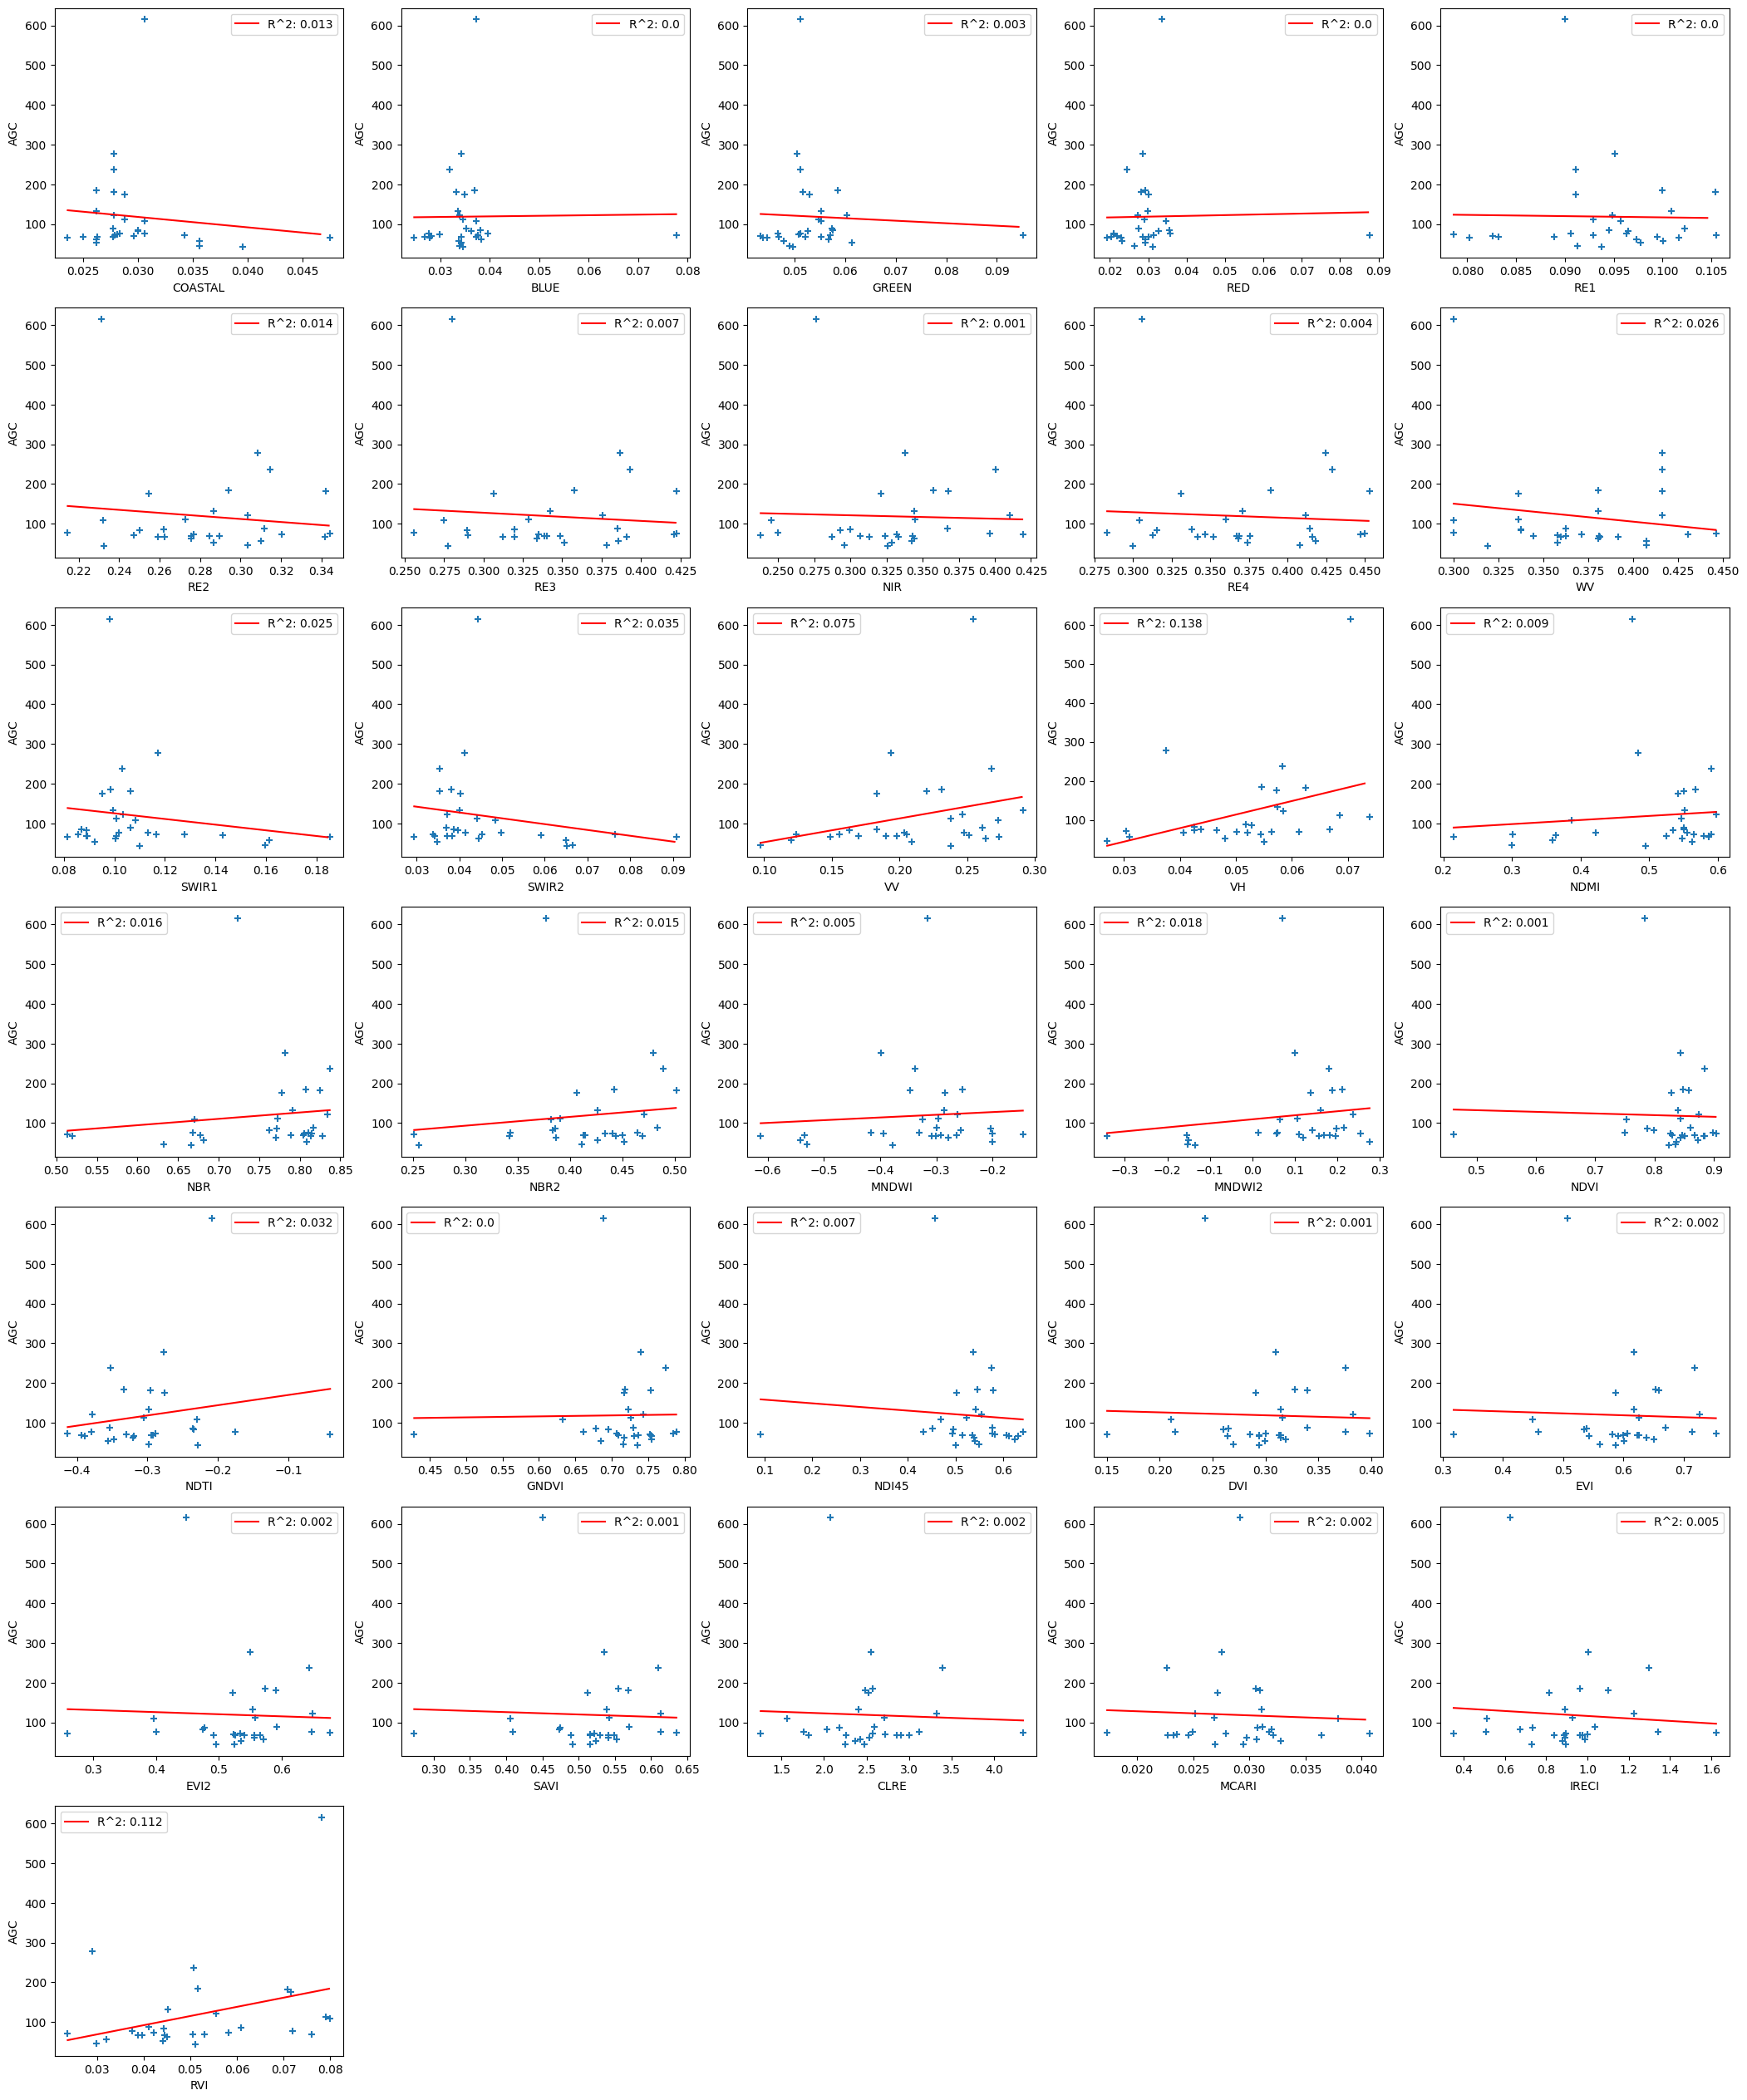

In [67]:
# Calculate the R2 correlation per bands
# Plot correlation between AGB and variables/features

# Correlate between band and label
label = "AGC"
bands = extract.columns[1:]

# List of features and its correlation ** 2
features_corr = []

plt.figure(figsize=(26, 32))
for x in range(len(bands)):
    band = bands[x]
    sample_band = extract[bands[x]]

    # Calculate stddev and mean
    std_dev = np.std(sample_band)
    mean = np.mean(sample_band)

    # Outlier mask
    filter_multiplier = 10
    mask = (sample_band > (mean - std_dev * filter_multiplier)) & (
        sample_band < (mean + std_dev * filter_multiplier)
    )

    # Only use normalized data
    sample_band = sample_band[mask]
    sample_label = extract[label][mask]

    # Calculate trend
    poly = 1
    trend = np.polyfit(sample_band, sample_label, poly)
    predict = np.poly1d(trend)

    # Min max
    min_x = np.min(sample_band)
    max_x = np.max(sample_band)

    # Make trendline
    trend_x = np.arange(min_x, max_x, 0.001)
    trend_y = predict(trend_x)

    # Calculate R2
    r2 = round(np.corrcoef(sample_label, predict(sample_band))[0, 1] ** 2, 3)

    # Append it to list
    features_corr.append(dict(band=band, r2=r2))

    plt.subplot(7, 5, x + 1)
    plt.scatter(sample_band, sample_label, marker="+")
    plt.xlabel(band)
    plt.ylabel(label)
    plt.plot(trend_x, trend_y, color="red", label=f"R^2: {r2}")
    plt.legend()

# Make list into dataframe
features_corr = pd.DataFrame(features_corr).sort_values("r2", ascending=False)
print("Correlation between AGB and bands sorted by the highest")
features_corr

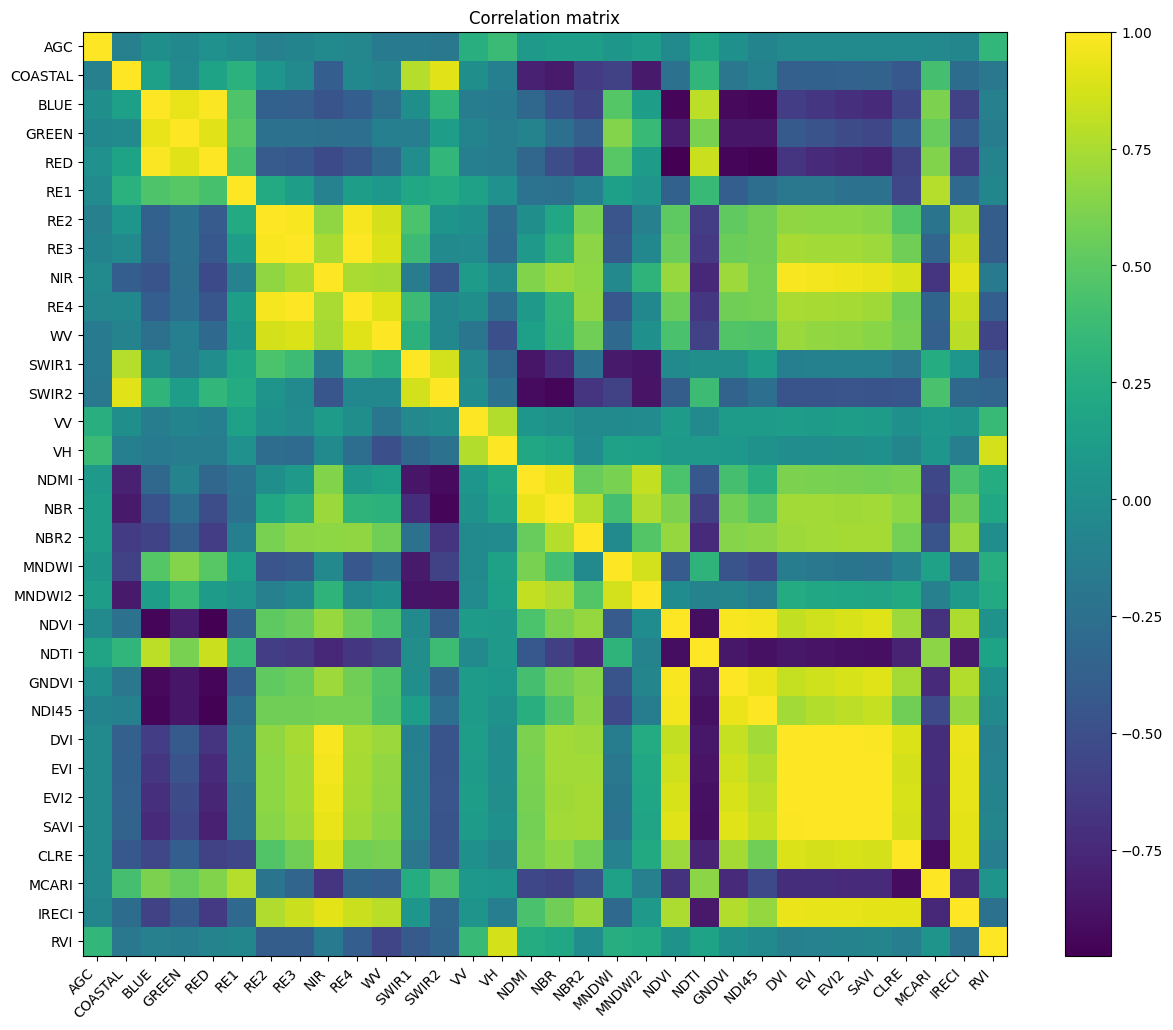

In [69]:
# Correlation matrix between features
corr = extract.corr()
plt.figure(figsize=(15, 12))
plt.title("Correlation matrix")
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.columns)
plt.show()
